<font size="6">**<center>Mortgage Data Preparation and EDA**</font>

#  Change Log

Date 10/20/2023.
1. Added change log.
2. Added Milestone 3. Please see section 5.
3. Added ethical assessment

Date 11/5/2023.
1. Added origination date variable to the flat file. Please see step 6 of section 4.3
2. Added milestone 4. Please see Section 6.
3. Updated the ethical assessment of the project. Please see section 9.

Date 11/9/2023
1. Added milestone 1.This was originally seperately submitted. Please see Section 3.
2. Added Milestone 5. Please see section 7.
3. Added Lessons Learned. Please see section 8.
4. Added Final data printout. Please see section 10.

#  Libraries

In [1]:
# Importing the necessary libraries.
import pandas as pd
from datetime import datetime
import requests
from bs4 import BeautifulSoup as bs
import warnings
import json
import fredapi as fa
from datetime import date
from dateutil.relativedelta import relativedelta
from tqdm import tqdm # version 4.62.2
tqdm.pandas(desc="% Complete!") #  Register `pandas.progress apply with `tqdm`. This allows to track percentage completed.
import sqlite3 as sq
import matplotlib.pyplot as plt
import seaborn as sns

# Milestone 1 - Identify Datasets

## Introduction

<div style ="text-align:justify">The purpose of this project is to source, clean, format, and visualize a home loan (or mortgage) dataset as well as check if some variables have a relationship with the likelihood of a homeowner prepaying their loan.</div>

## Data Sources

<div style ="text-align:justify">To achieve the purpose of this project, data will be extracted from the following three sources:</br>

1. Microsoft Excel flat file – This is Freddie Mac's Single-Family Loan-Level data set, which contains 27 columns and 500,137 rows. It has a binary variable that indicates whether the loan was prepaid or not. Additionally, it has other loan-level attributes such as origination term, maturity date, credit score, property state, etc. The data set is stored at the following location:

   https://s3.amazonaws.com/data.h2o.ai/DAI-Tutorials/loan_level_500k.csv
   </br>

2. The FRED® API – This is an Application Programming Interface (API) that allows users to retrieve economic data from the FRED® website. In this project, this API will be used to pull macroeconomic variables that can potentially drive mortgage prepayment risk such as US unemployment rates, Home Price Index and Inflation rates. General documentation of the FRED® API can be found on the following link: 

   https://fred.stlouisfed.org/docs/api/fred/
   </br>

3. Website – The following website has a table which consists of tax dollars by state:

   https://money.cnn.com/pf/features/lists/total_taxes/total.html
   </br>

The table will be scrapped from the website to extract the rankings of the state based on the amount of taxes paid by residents. This will be used to visualize whether state taxes are associated with the likelihood of a homeowner prepaying their loan.</div>

## Relationships

<div style ="text-align:justify">
The Microsoft Excel flat file and data from the website are related in that they have one attribute “State” as a common key. Thus, they can be merged using the “State” variable as a common key. However, this combined dataset would not have a relationship with data from the FRED® API. To create that relationship, the origination date variable will be created in the Microsoft Excel flat file by subtracting the term of the loan (in months) from the maturity date. The range of the resultant origination dates in the flat file will then be used as the date range to pull macroeconomic variables from the FRED® API. Thus, macroeconomic data pulled from the API will characterize the economic environment at the time the loan was originated.</br>   

In short, the flat file will be merged with website data on the “State” variable, and this combined data will be merged with the FRED® API data on the origination date variable that will be created in the flat file.
</div>


## Project Approach

<div style ="text-align:justify">
The combined data from all three sources characterizes Mortgages that were prepaid under varying economic conditions and state tax levels. Through Python data visualization techniques and descriptive statistics learned in the Data Preparation Class, this project will attempt to analyze key drivers of Mortgage repayment risk. Is Mortgage prepayment risk primarily driven by loan level attributes such as Credit Score and Loan-to-value? Or is it driven by a combination of loan-level attributes and economic conditions or state tax levels? These and other questions will be answered in order to understand key drivers of mortgage prepayment risk. While not exhaustive, the following is a list of key Python packages that will be utilized in the project:</br>

- Pandas – This will be used to load and manipulate the data.
- Numpy – This will be used to perform mathematical operations if need be.
- Matplotlib – This will be utilized to construct graphs as part of visualizations.
</div>

## Anticipated Challenges

<div style ="text-align:justify">
    
- The data that will be scrapped from the website will not be in a ready–for–analysis form and it will need to be programmatically transformed before being merged with the flat file. 
- Values of some categorical variables do not have correct formats.  During data manipulation, these values will have to be correctly formatted after researching what the categorical variable means and what range of values they are able to take.

The above two challenges will be time-consuming but necessary in accomplishing the objective of the project.
</div>

#  Milestone 2 - Cleaning/Formatting Flat File Source

##  Loading the data

In [2]:
#Loading the data
mortgage_df =pd.read_csv('https://s3.amazonaws.com/data.h2o.ai/DAI-Tutorials/loan_level_500k.csv')

#Checking if data has loaded successfully by looking at the first 10 rows.
mortgage_df.head(10)

,CREDIT_SCORE,FIRST_PAYMENT_DATE,FIRST_TIME_HOMEBUYER_FLAG,MATURITY_DATE,METROPOLITAN_STATISTICAL_AREA,MORTGAGE_INSURANCE_PERCENTAGE,NUMBER_OF_UNITS,OCCUPANCY_STATUS,ORIGINAL_COMBINED_LOAN_TO_VALUE,ORIGINAL_DEBT_TO_INCOME_RATIO,...,PROPERTY_TYPE,POSTAL_CODE,LOAN_SEQUENCE_NUMBER,LOAN_PURPOSE,ORIGINAL_LOAN_TERM,NUMBER_OF_BORROWERS,SELLER_NAME,SERVICER_NAME,PREPAID,DELINQUENT
0,669.0,200206,N,202901,NaN,0.0,1.0,O,80.0,33.0,...,SF,26100.0,F199Q1000004,P,320,2.0,Other sellers,Other servicers,True,False
1,732.0,199904,N,202903,17140.0,0.0,1.0,O,25.0,10.0,...,SF,45200.0,F199Q1000005,N,360,1.0,Other sellers,Other servicers,True,False
2,679.0,200208,N,202902,15940.0,30.0,1.0,O,91.0,48.0,...,SF,44700.0,F199Q1000007,P,319,1.0,Other sellers,Other servicers,True,False
3,721.0,200209,N,202902,38060.0,0.0,1.0,O,39.0,13.0,...,SF,85200.0,F199Q1000013,N,318,2.0,Other sellers,Other servicers,True,False
4,618.0,200210,N,202902,10420.0,25.0,1.0,O,85.0,24.0,...,SF,44200.0,F199Q1000015,N,317,2.0,Other sellers,Other servicers,True,False
5,738.0,200211,N,202903,10420.0,0.0,1.0,O,73.0,44.0,...,SF,44300.0,F199Q1000016,P,317,2.0,Other sellers,Other servicers,True,False
6,761.0,200211,N,202904,NaN,0.0,1.0,O,73.0,31.0,...,PU,29500.0,F199Q1000017,P,318,2.0,Other sellers,Other servicers,True,False
7,707.0,200211,N,202903,33340.0,0.0,1.0,O,60.0,57.0,...,SF,53000.0,F199Q1000018,C,317,2.0,Other sellers,Other servicers,True,False
8,760.0,200211,N,202903,33340.0,0.0,1.0,O,63.0,30.0,...,SF,53000.0,F199Q1000019,N,317,2.0,Other sellers,Other servicers,True,False
9,691.0,200302,N,202901,15940.0,0.0,1.0,O,65.0,25.0,...,SF,44700.0,F199Q1000023,P,312,2.0,Other sellers,Other servicers,True,False


The data has loaded successfully based on the first 10 rows.

##  Data Validation

In [3]:
# Checking the dataframe information.
mortgage_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500137 entries, 0 to 500136
Data columns (total 27 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   CREDIT_SCORE                      497426 non-null  float64
 1   FIRST_PAYMENT_DATE                500137 non-null  int64  
 2   FIRST_TIME_HOMEBUYER_FLAG         369578 non-null  object 
 3   MATURITY_DATE                     500137 non-null  int64  
 4   METROPOLITAN_STATISTICAL_AREA     429988 non-null  float64
 5   MORTGAGE_INSURANCE_PERCENTAGE     449089 non-null  float64
 6   NUMBER_OF_UNITS                   500134 non-null  float64
 7   OCCUPANCY_STATUS                  500137 non-null  object 
 8   ORIGINAL_COMBINED_LOAN_TO_VALUE   500124 non-null  float64
 9   ORIGINAL_DEBT_TO_INCOME_RATIO     485208 non-null  float64
 10  ORIGINAL_UPB                      500137 non-null  int64  
 11  ORIGINAL_LOAN_TO_VALUE            500128 non-null  f

Based on the above output, the following was observations were made:
1. The FIRST_PAYMENT_DATE and MATURITY_DATE variables have the 'int64' data type. This needs to be changed to datetime data type.

2. The Non-Null count for the variables in the dataframe is different. This suggests that some observations may have missing values. Missing values will be checked and treated as appropriate.

3. Since an analysis of mortgage prepayment drivers will be conducted, variables such as  METROPOLITAN_STATISTICAL_AREA,POSTAL_CODE, and LOAN_SEQUENCE_NUMBER may not add value to this analysis. These variables will be dropped.

In [4]:
#Checking missing values.
len(mortgage_df)
missing_values = mortgage_df.isnull().sum()
missng_value_percentage = (missing_values/len(mortgage_df))*100
missng_value_percentage

CREDIT_SCORE                         0.542051
FIRST_PAYMENT_DATE                   0.000000
FIRST_TIME_HOMEBUYER_FLAG           26.104647
MATURITY_DATE                        0.000000
METROPOLITAN_STATISTICAL_AREA       14.025957
MORTGAGE_INSURANCE_PERCENTAGE       10.206803
NUMBER_OF_UNITS                      0.000600
OCCUPANCY_STATUS                     0.000000
ORIGINAL_COMBINED_LOAN_TO_VALUE      0.002599
ORIGINAL_DEBT_TO_INCOME_RATIO        2.984982
ORIGINAL_UPB                         0.000000
ORIGINAL_LOAN_TO_VALUE               0.001800
ORIGINAL_INTEREST_RATE               0.000000
CHANNEL                              0.000000
PREPAYMENT_PENALTY_MORTGAGE_FLAG     1.035316
PRODUCT_TYPE                         0.000000
PROPERTY_STATE                       0.000000
PROPERTY_TYPE                        0.018995
POSTAL_CODE                          0.006198
LOAN_SEQUENCE_NUMBER                 0.000000
LOAN_PURPOSE                         0.000000
ORIGINAL_LOAN_TERM                

For this project, missing values will be dropped if they only account for less than 5% of the observations for these variables:  NUMBER_OF_BORROWERS, PROPERTY_TYPE, PREPAYMENT_PENALTY_MORTGAGE_FLAG and NUMBER_OF_UNITS.Imputated values for these variables may be far from being true.

Additionally, missing values will be imputated if they account for less than 5% of the following variables:CREDIT_SCORE,ORIGINAL_COMBINED_LOAN_TO_VALUE, ORIGINAL_DEBT_TO_INCOME_RATIO and ORIGINAL_LOAN_TO_VALUE. 

Lastly, variables with missing values above 5% will be dropped. 

In [5]:
# Selecting duplicate rows except first. Occurrence based on all columns
duplicate = mortgage_df[mortgage_df.duplicated()]
duplicate 

,CREDIT_SCORE,FIRST_PAYMENT_DATE,FIRST_TIME_HOMEBUYER_FLAG,MATURITY_DATE,METROPOLITAN_STATISTICAL_AREA,MORTGAGE_INSURANCE_PERCENTAGE,NUMBER_OF_UNITS,OCCUPANCY_STATUS,ORIGINAL_COMBINED_LOAN_TO_VALUE,ORIGINAL_DEBT_TO_INCOME_RATIO,...,PROPERTY_TYPE,POSTAL_CODE,LOAN_SEQUENCE_NUMBER,LOAN_PURPOSE,ORIGINAL_LOAN_TERM,NUMBER_OF_BORROWERS,SELLER_NAME,SERVICER_NAME,PREPAID,DELINQUENT


There are no duplicate rows in the data set.

In [6]:
# Validating data ranges
mortgage_df.describe().loc[['min','max']]

,CREDIT_SCORE,FIRST_PAYMENT_DATE,MATURITY_DATE,METROPOLITAN_STATISTICAL_AREA,MORTGAGE_INSURANCE_PERCENTAGE,NUMBER_OF_UNITS,ORIGINAL_COMBINED_LOAN_TO_VALUE,ORIGINAL_DEBT_TO_INCOME_RATIO,ORIGINAL_UPB,ORIGINAL_LOAN_TO_VALUE,ORIGINAL_INTEREST_RATE,POSTAL_CODE,ORIGINAL_LOAN_TERM,NUMBER_OF_BORROWERS
min,300.0,199901.0,202402.0,10180.0,0.0,1.0,6.0,1.0,8000.0,6.0,4.625,600.0,301.0,1.0
max,839.0,201103.0,204101.0,49740.0,55.0,4.0,180.0,65.0,578000.0,100.0,11.500,99900.0,362.0,2.0


The range of  values in all variables appear to be good so far.

##  Data transformation and/or cleansing steps

    Step 1 : Dropping Variables with more than 5 % of missing values.

In [7]:
# Dropping FIRST_TIME_HOMEBUYER_FLAG,METROPOLITAN_STATISTICAL_AREA, MORTGAGE_INSURANCE_PERCENTAGE 
small_mortgage_df = mortgage_df.drop(['FIRST_TIME_HOMEBUYER_FLAG', 'METROPOLITAN_STATISTICAL_AREA',
                                     'MORTGAGE_INSURANCE_PERCENTAGE'], axis=1)

In [8]:
# Checking shape after dropping variables.
small_mortgage_df.shape[1]

24

The number of columns has reduced from 27 to 24. The dropping was successful.

    Step 2: Dropping variables which wouldn't add value in the analysis of drivers of mortgage prepayment.

In [9]:
# Dropping Postal code POSTAL_CODE, LOAN_SEQUENCE_NUMBER
small_mortgage_df = small_mortgage_df.drop(['POSTAL_CODE','LOAN_SEQUENCE_NUMBER'],axis=1)
small_mortgage_df.shape[1]

22

The number of columns has reduced from 24 to 22. The dropping was successful.

    Step 3 : Imputing missing values

The distribution of variables with missing values will be checked prior to imputation.

array([[<Axes: title={'center': 'CREDIT_SCORE'}>]], dtype=object)

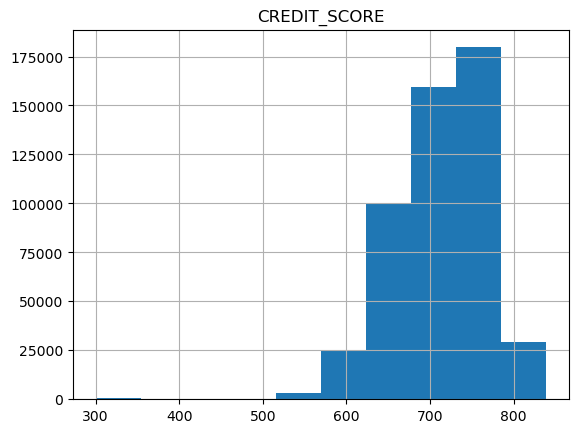

In [10]:
# Histogram of credit score
small_mortgage_df.hist('CREDIT_SCORE')

Credit_score appears to be approximately normal. Thus, the mean will be used to impute missing values.

In [11]:
# Imputing missing credit score values.
mean = round(small_mortgage_df['CREDIT_SCORE'].mean())
small_mortgage_df['CREDIT_SCORE'].fillna(value=mean, inplace=True) 

array([[<Axes: title={'center': 'ORIGINAL_DEBT_TO_INCOME_RATIO'}>]],
      dtype=object)

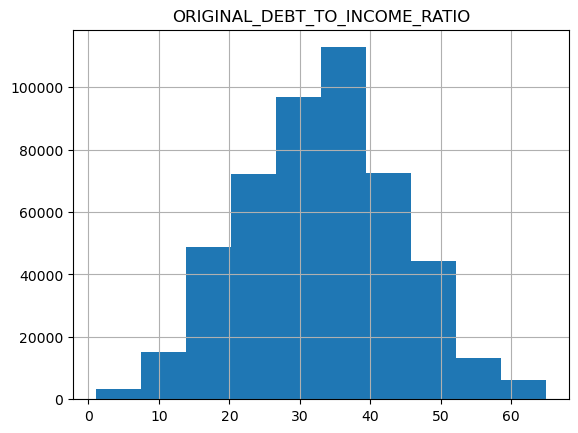

In [12]:
# Histogram of ORIGINAL_DEBT_TO_INCOME_RATIO 
small_mortgage_df.hist('ORIGINAL_DEBT_TO_INCOME_RATIO')

The original_debt_to_income_ratio appears to be approximately normal. Thus, mean will be used to impute missing values.

array([[<Axes: title={'center': 'ORIGINAL_LOAN_TO_VALUE'}>]], dtype=object)

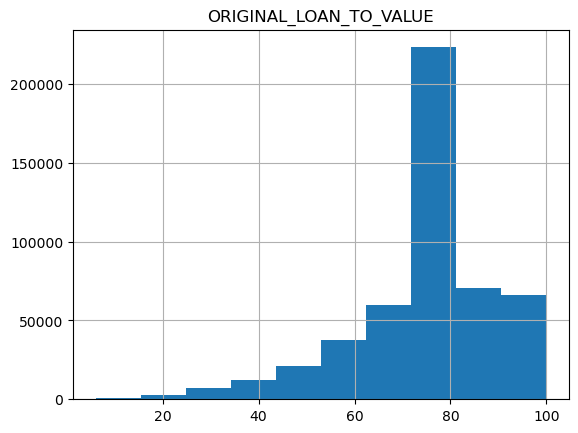

In [13]:
# Histogram of ORIGINAL_LOAN_TO_VALUE 
small_mortgage_df.hist('ORIGINAL_LOAN_TO_VALUE')

The distribution of ORIGINAL_LOAN_TO_VALUE is skewed. Thus, the median will be used to impute missing values.

In [14]:
# Imputing missing values of the ORIGINAL_LOAN_TO_VALUE
median = round(small_mortgage_df['ORIGINAL_LOAN_TO_VALUE'].median())
small_mortgage_df['ORIGINAL_LOAN_TO_VALUE'].fillna(value=median, inplace=True)

array([[<Axes: title={'center': 'ORIGINAL_COMBINED_LOAN_TO_VALUE'}>]],
      dtype=object)

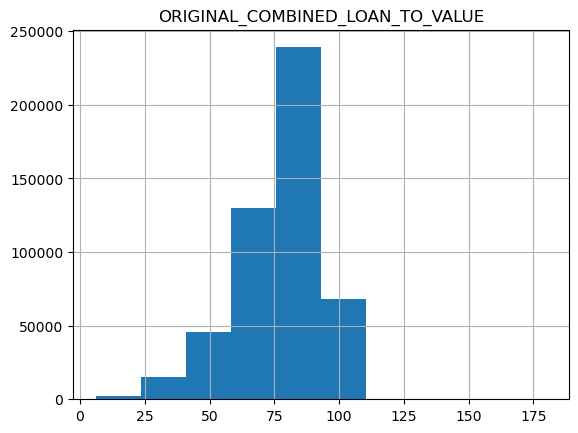

In [15]:
# Histogram of ORIGINAL_COMBINED_LOAN_TO_VALUE
small_mortgage_df.hist('ORIGINAL_COMBINED_LOAN_TO_VALUE')

The ORIGINAL_COMBINED_LOAN_TO_VALUE appeared to be skewed to the left. The median will be used to impute missing values.

In [16]:
median_combined = round(small_mortgage_df['ORIGINAL_COMBINED_LOAN_TO_VALUE'].median())
small_mortgage_df['ORIGINAL_COMBINED_LOAN_TO_VALUE'].fillna(value=median_combined, inplace=True)

array([[<Axes: title={'center': 'ORIGINAL_DEBT_TO_INCOME_RATIO'}>]],
      dtype=object)

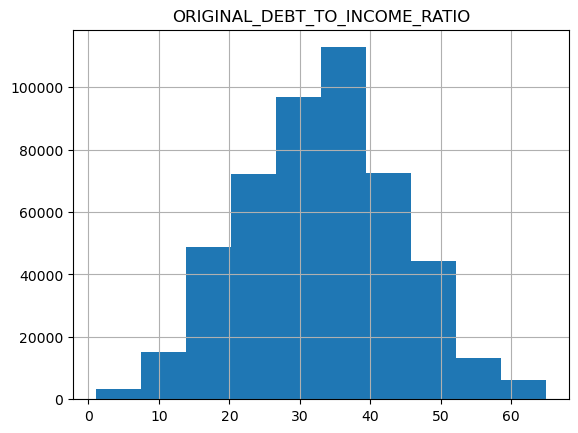

In [17]:
# Histogram of  ORIGINAL_DEBT_TO_INCOME_RATIO
small_mortgage_df.hist('ORIGINAL_DEBT_TO_INCOME_RATIO')

The ORIGINAL_DEBT_TO_INCOME_RATIO is normally distributed and the mean will be used to impute the missing values.

In [18]:
# Imputing missing credit score values.
mean = round(small_mortgage_df['ORIGINAL_DEBT_TO_INCOME_RATIO'].mean())
small_mortgage_df['ORIGINAL_DEBT_TO_INCOME_RATIO'].fillna(value=mean, inplace=True)

    Step 4 : Dropping rows for variables with less than 5% of missing values. 

Dropping makes sense in the case of the variables below because the imputing may not really reflect what the actual value might have been.

In [19]:
# NUMBER_OF_UNITS
small_mortgage_df = small_mortgage_df[small_mortgage_df['NUMBER_OF_UNITS'].notna()]

In [20]:
# PROPERTY_TYPE
small_mortgage_df = small_mortgage_df[small_mortgage_df['PROPERTY_TYPE'].notna()]

In [21]:
# PREPAYMENT_PENALTY_MORTGAGE_FLAG
small_mortgage_df = small_mortgage_df[small_mortgage_df['PREPAYMENT_PENALTY_MORTGAGE_FLAG'].notna()]

In [22]:
small_mortgage_df = small_mortgage_df[small_mortgage_df['NUMBER_OF_BORROWERS'].notna()]

    Step 5 : Converting date variables to datetime datatypes.

In [23]:
# FIRST_PAYMENT_DATE
small_mortgage_df['FIRST_PAYMENT_DATE'] = small_mortgage_df['FIRST_PAYMENT_DATE'].progress_apply(lambda x: pd.to_datetime(str(x),format='%Y%m'))

% Complete!: 100%|██████████| 494615/494615 [00:50<00:00, 9861.66it/s] 


In [24]:
# MATURITY_DATE 
small_mortgage_df['MATURITY_DATE'] = small_mortgage_df['MATURITY_DATE'].progress_apply(lambda x: pd.to_datetime(str(x),format='%Y%m'))

% Complete!: 100%|██████████| 494615/494615 [00:51<00:00, 9653.03it/s] 


In [25]:
small_mortgage_df.head()

,CREDIT_SCORE,FIRST_PAYMENT_DATE,MATURITY_DATE,NUMBER_OF_UNITS,OCCUPANCY_STATUS,ORIGINAL_COMBINED_LOAN_TO_VALUE,ORIGINAL_DEBT_TO_INCOME_RATIO,ORIGINAL_UPB,ORIGINAL_LOAN_TO_VALUE,ORIGINAL_INTEREST_RATE,...,PRODUCT_TYPE,PROPERTY_STATE,PROPERTY_TYPE,LOAN_PURPOSE,ORIGINAL_LOAN_TERM,NUMBER_OF_BORROWERS,SELLER_NAME,SERVICER_NAME,PREPAID,DELINQUENT
0,669.0,2002-06-01,2029-01-01,1.0,O,80.0,33.0,162000,80.0,7.120,...,FRM,WV,SF,P,320,2.0,Other sellers,Other servicers,True,False
1,732.0,1999-04-01,2029-03-01,1.0,O,25.0,10.0,53000,25.0,6.500,...,FRM,OH,SF,N,360,1.0,Other sellers,Other servicers,True,False
2,679.0,2002-08-01,2029-02-01,1.0,O,91.0,48.0,133000,91.0,6.750,...,FRM,OH,SF,P,319,1.0,Other sellers,Other servicers,True,False
3,721.0,2002-09-01,2029-02-01,1.0,O,39.0,13.0,174000,39.0,6.625,...,FRM,AZ,SF,N,318,2.0,Other sellers,Other servicers,True,False
4,618.0,2002-10-01,2029-02-01,1.0,O,85.0,24.0,122000,85.0,6.375,...,FRM,OH,SF,N,317,2.0,Other sellers,Other servicers,True,False


The FIRST_PAYMENT_DATE and MATURITY_DATE variables have been successfully converted to datetime data type.

    Step 6: Adding the origination date to the dataframe.

In [26]:
# Defining the Add Months function
def add_months(start_date, delta_period):
    end_date = start_date + relativedelta(months=delta_period)
    return end_date

In [27]:
# Multiplying origination term by -1. This will help to decrement maturity by the original term loan
# inorder to calculate the origination date.
small_mortgage_df['ORIGINAL_LOAN_TERM'] = small_mortgage_df['ORIGINAL_LOAN_TERM'].progress_apply(lambda x: x*-1)

% Complete!: 100%|██████████| 494615/494615 [00:00<00:00, 976821.03it/s] 


In [28]:
# Apply Add_month function on the dataframe using lambda operation.
small_mortgage_df['Origination_date'] = small_mortgage_df.progress_apply(lambda row: add_months(row['MATURITY_DATE'], row['ORIGINAL_LOAN_TERM']), axis = 1)

% Complete!: 100%|██████████| 494615/494615 [00:19<00:00, 25791.92it/s]


In [29]:
# Checking if the variable has been created successfully.
small_mortgage_df['Origination_date']

0        2002-05-01
1        1999-03-01
2        2002-07-01
3        2002-08-01
4        2002-09-01
            ...    
500132   2002-02-01
500133   2002-02-01
500134   2002-02-01
500135   2002-02-01
500136   2002-02-01
Name: Origination_date, Length: 494615, dtype: datetime64[ns]

The origination variable has been successfully created.

In [30]:
# Identifying the minimum origination date.
minimum_date=min(small_mortgage_df['Origination_date'])
print("The oldest loan was originated on ", minimum_date)

The oldest loan was originated on  1998-12-01 00:00:00


In [31]:
# Identifying the maximum origination date.
maximum_date=max(small_mortgage_df['Origination_date'])
print("The most recent loan was originated on ", maximum_date)

The most recent loan was originated on  2011-02-01 00:00:00


In [32]:
# Checking the information of the flat file after transformation.
small_mortgage_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 494615 entries, 0 to 500136
Data columns (total 23 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   CREDIT_SCORE                      494615 non-null  float64       
 1   FIRST_PAYMENT_DATE                494615 non-null  datetime64[ns]
 2   MATURITY_DATE                     494615 non-null  datetime64[ns]
 3   NUMBER_OF_UNITS                   494615 non-null  float64       
 4   OCCUPANCY_STATUS                  494615 non-null  object        
 5   ORIGINAL_COMBINED_LOAN_TO_VALUE   494615 non-null  float64       
 6   ORIGINAL_DEBT_TO_INCOME_RATIO     494615 non-null  float64       
 7   ORIGINAL_UPB                      494615 non-null  int64         
 8   ORIGINAL_LOAN_TO_VALUE            494615 non-null  float64       
 9   ORIGINAL_INTEREST_RATE            494615 non-null  float64       
 10  CHANNEL                           494

The data types look good and the non-null count for all variables is same. So far so good with the flat file.

#  Milestone 3 - Cleaning/Formatting Website Data

##  Connection to the webpage

In [33]:
# Load the webpage content. Try blocks will be used to ensure successful connection to the wikipedia link
try:
    connection_to_webpage = requests.get("https://money.cnn.com/pf/features/lists/total_taxes/total.html")
    connection_to_webpage.raise_for_status()
    
    # Convert to the webpage to a beutifulsoup object
    soup = bs(connection_to_webpage.text, 'html.parser')
    print('Connection to the webpage was successful.')
    
except Exception:
    print("An error occured when connecting to the website. Check the link and try again.")

Connection to the webpage was successful.


##  Scrapping the data table

In [34]:
# Generating the right table using its index. The index was identified through visual inspection.
data_table = soup.find_all('table')[4] # The needed table has an index position of 4.
print(type(data_table))

<class 'bs4.element.Tag'>


In [35]:
# Extracting first level column names.
first_level_headers = data_table.find_all('tr',recursive=False)[0]
first_level_headers_list = sources_list = [td for td in first_level_headers.find_all('td')]
first_level_names = [name.text.replace('*','') for name in first_level_headers_list]
print(first_level_names)

['State', 'Personal income tax', 'Sales and excise taxes', 'Total taxes']


In [36]:
# Extracting Second level column names
second_level_headers = data_table.find_all('tr',recursive=False)[1]
second_level_headers_list = sources_list = [td for td in second_level_headers.find_all('td')]
second_level_names = [name.text for name in second_level_headers_list]
print(second_level_names)

['Tax $ per $1000', 'Rank', 'Tax $ per $1000', 'Rank', 'Tax $ per $1000', 'Rank']


In [37]:
# Extracting data
warnings.filterwarnings("ignore", category=FutureWarning)  # This was put here to suppress non concerning warnings.

#Extracting the data and appending it to a dataframe the rows.
tax_df=pd.DataFrame()
rows = data_table.find_all('tr',recursive=False)[2:]
for i in rows:
    values = i.find_all('td')
    row =[tr.text.strip() for tr in values]
        # Appending each row in a dataframe
    tax_df = pd.concat([tax_df, pd.DataFrame([row])], ignore_index=True)

In [38]:
# Making the state column as an index
tax_df = tax_df.set_index(tax_df.columns[0])

In [39]:
# Assingning the name to the set index.
tax_df.index.name = first_level_names[0]
tax_df.columns

Index([1, 2, 3, 4, 5, 6], dtype='int64')

In [40]:
# Creating the the two level column names for the data table from the webpage.
columns =  pd.MultiIndex.from_product([first_level_names[1:],second_level_names[0:2]])

In [41]:
# Adding the column names to the dataframe and outputting the scrapped table
tax_df.columns= columns
tax_df

Personal income tax       \
                                                       Tax $ per $1000 Rank   
State                                                                         
New York                                                         44.45    1   
Maine                                                            30.75   11   
Wyoming                                                           0.00   45   
Hawaii                                                           31.63    9   
Wisconsin                                                        31.34   10   
Rhode Island                                                     25.83   18   
Minnesota                                                        33.37    6   
West Virginia                                                    24.90   24   
New Mexico                                                       22.46   33   
Louisiana                                                        16.34   38   
Ohio                                                             36.18    4   
Vermont                                                          22.95   31   
Utah                                                             28.88   14   
Nebraska                                                         23.37   28   
Delaware                                                         30.47   12   
Kentucky                                                         34.45    5   
California                                                       29.09   13   
North Dakota                                                     12.14   41   
Arizona                                                          15.15   40   
Maryland                                                         40.16    2   
New Jersey                                                       20.66   35   
Arkansas                                                         25.21   22   
Mississippi                                                      15.69   39   
Iowa                                                             22.62   32   
Michigan                                                         22.35   34   
Kansas                                                           24.11   26   
Connecticut                                                      25.23   21   
Alaska                                                            0.00   45   
Illinois                                                         18.21   37   
Nevada                                                            0.00   45   
Pennsylvania                                                     25.51   20   
Washington                                                        0.00   45   
Indiana                                                          24.36   25   
Georgia                                                          27.06   16   
North Carolina                                                   32.24    7   
Idaho                                                            25.56   19   
Oklahoma                                                         25.91   17   
Montana                                                          23.77   27   
Missouri                                                         24.95   23   
Massachusetts                                                    31.75    8   
South Carolina                                                   23.08   29   
Texas                                                             0.00   44   
Virginia                                                         28.86   15   
Florida                                                           0.00   45   
Colorado                                                         23.08   30   
Oregon                                                           37.12    3   
South Dakota                                                      0.00   45   
Alabama                                                          19.16   36   
New Hampshire         

The above output shows how the table looks like on the webpage, except for the last row. Now, a few transformations will be performed to clean the table.

## Data transformation and/or cleansing steps

    Step 1: Dropping first level column names.

In [42]:
# Dropping first level column name.
tax_df=tax_df.droplevel(0, axis='columns')
tax_df.head()

,Tax $ per $1000,Rank,Tax $ per $1000,Rank,Tax $ per $1000,Rank
State,,,,,,
New York,44.45,1,33.10,36,130.79,1
Maine,30.75,11,35.59,29,130.16,2
Wyoming,0.00,45,46.38,13,121.97,3
Hawaii,31.63,9,63.85,1,120.62,4
Wisconsin,31.34,10,35.90,28,117.26,5


The first level column names were successfully dropped.

    Step 2: Resetting the index for the dataframe.

In [43]:
# Resetting the index
tax_df = tax_df.reset_index()
tax_df.head()

,State,Tax $ per $1000,Rank,Tax $ per $1000,Rank,Tax $ per $1000,Rank
0,New York,44.45,1,33.10,36,130.79,1
1,Maine,30.75,11,35.59,29,130.16,2
2,Wyoming,0.00,45,46.38,13,121.97,3
3,Hawaii,31.63,9,63.85,1,120.62,4
4,Wisconsin,31.34,10,35.90,28,117.26,5


The reset was successful.

    Step 3: Rename the second level column names.

In [44]:
# Creating new column names.
new_names = ['State','Personal taxes per $1000','Rank_one','State_and_sales taxes per $1000','Rank_two','Total_Taxes_per_$1000','State_tax_Rank']

# Applying new column names
tax_df.columns=new_names
tax_df.head()

,State,Personal taxes per $1000,Rank_one,State_and_sales taxes per $1000,Rank_two,Total_Taxes_per_$1000,State_tax_Rank
0,New York,44.45,1,33.10,36,130.79,1
1,Maine,30.75,11,35.59,29,130.16,2
2,Wyoming,0.00,45,46.38,13,121.97,3
3,Hawaii,31.63,9,63.85,1,120.62,4
4,Wisconsin,31.34,10,35.90,28,117.26,5


Renaming the columns was successful.

    Step 4: Remove the last row of the data, since it does not contain any valuable information.

In [45]:
# Checking the row to be dropped.
tax_df.tail(1)

,State,Personal taxes per $1000,Rank_one,State_and_sales taxes per $1000,Rank_two,Total_Taxes_per_$1000,State_tax_Rank
50,"* Includes property taxes, personal income tax...",NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
# Dropping the last row.
tax_df= tax_df.iloc[:-1,:]
tax_df.tail()

,State,Personal taxes per $1000,Rank_one,State_and_sales taxes per $1000,Rank_two,Total_Taxes_per_$1000,State_tax_Rank
45,Oregon,37.12,3,8.98,50,90.93,46
46,South Dakota,0.00,45,45.64,15,90.37,47
47,Alabama,19.16,36,43.25,16,87.58,48
48,New Hampshire,1.68,42,14.24,48,84.65,49
49,Tennessee,0.95,43,48.24,9,83.89,50


The last row has been successfully dropped.

    Step 5: Adding State Abbreviation to the data.(This will be used when merging with the flat file)

In [47]:
# Creating a dictionary of US states and their abbreviations.
us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "U.S. Virgin Islands": "VI",
}

In [48]:
tax_df['State_abbreviation'] = tax_df['State'].map(us_state_to_abbrev)

In [49]:
tax_df.head()

,State,Personal taxes per $1000,Rank_one,State_and_sales taxes per $1000,Rank_two,Total_Taxes_per_$1000,State_tax_Rank,State_abbreviation
0,New York,44.45,1,33.10,36,130.79,1,NY
1,Maine,30.75,11,35.59,29,130.16,2,ME
2,Wyoming,0.00,45,46.38,13,121.97,3,WY
3,Hawaii,31.63,9,63.85,1,120.62,4,HI
4,Wisconsin,31.34,10,35.90,28,117.26,5,WI


The mapping to the state abbreviation was successful. Since Personal,state and sales taxes are included in total taxes, they will be dropped along with their ranks.

    Setp 6 : Retaining only total taxes, rank and state abbreviation.

In [50]:
tax_df = tax_df[['Total_Taxes_per_$1000','State_tax_Rank','State_abbreviation']]
tax_df

,Total_Taxes_per_$1000,State_tax_Rank,State_abbreviation
0,130.79,1,NY
1,130.16,2,ME
2,121.97,3,WY
3,120.62,4,HI
4,117.26,5,WI
5,113.63,6,RI
6,113.14,7,MN
7,111.68,8,WV
8,111.45,9,NM
9,111.26,10,LA


The website data looks good.

# Milestone 4 - Connecting to an API/Pulling in the Data and Cleaning/Formatting

## API Description

Fredapi is a Python API for the FRED data provided by the Federal Reserve Bank of St. Louis. fredapi provides a wrapper in python to the FRED web service, and also provides several conveninent methods for parsing and analyzing point-in-time data.

## Connection to the API

In [51]:
# Loading the fred_api key.
with open('D:/Training/Bellevue/Data Preparation/Data/fred_api_key.json') as f:
    keys = json.load(f)
    fred_api_key = keys['fred_api_key']

In [52]:
# Connecting to the API using the API key.
fred = fa.Fred(api_key=fred_api_key)
fred

Connection to the API was successful.

## Pulling the necessary variables.

In [53]:
# Pulling unemployment rate(UNRATE)
unrate = fred.get_series('UNRATE') 
unrate.name = 'unrate'
# Pulling Case-Shiller U.S. National Home Price Index (HPI)
CSUSHPINSA = fred.get_series('CSUSHPINSA') 
CSUSHPINSA.name ='CSUSHPINSA'
# Pulling  Consumer Price Index(CPI)
CPALTT01USM657N = fred.get_series('CPALTT01USM657N') 
CPALTT01USM657N.name = 'CPALTT01USM657N'

##  Data transformation and/or cleansing steps

    Step 1 : Merging the three variables into a pandas dataframe.

In [54]:
# Merging UNRATE and HPI
api_data = pd.merge(unrate,CSUSHPINSA, left_index= True, right_index=True)

# adding the CPI to the two variables.
api_data = pd.merge(api_data,CPALTT01USM657N, left_index= True, right_index=True)
api_data.head()

,unrate,CSUSHPINSA,CPALTT01USM657N
1975-01-01,8.1,NaN,0.385356
1975-02-01,8.1,NaN,0.767754
1975-03-01,8.6,NaN,0.380952
1975-04-01,8.8,NaN,0.379507
1975-05-01,9.0,NaN,0.567108


    Step 2 : Replacing headers.

In [55]:
# Creating new column names.
new_names = ['unemployment_rate','home_price_index','consumer_price_index',]

# Applying new column names
api_data.columns=new_names
api_data.head()

,unemployment_rate,home_price_index,consumer_price_index
1975-01-01,8.1,NaN,0.385356
1975-02-01,8.1,NaN,0.767754
1975-03-01,8.6,NaN,0.380952
1975-04-01,8.8,NaN,0.379507
1975-05-01,9.0,NaN,0.567108


Renaming columns was successfull.

    Step 3: Naming the index.

In [56]:
# Naming the index as year.
api_data.index.name = 'year'
api_data.head()

,unemployment_rate,home_price_index,consumer_price_index
year,,,
1975-01-01,8.1,NaN,0.385356
1975-02-01,8.1,NaN,0.767754
1975-03-01,8.6,NaN,0.380952
1975-04-01,8.8,NaN,0.379507
1975-05-01,9.0,NaN,0.567108


The index was successfully named.

    Step 4: Resetting the index.

In [57]:
# Resetting the index
api_data  = api_data .reset_index()
api_data .head()

,year,unemployment_rate,home_price_index,consumer_price_index
0,1975-01-01,8.1,NaN,0.385356
1,1975-02-01,8.1,NaN,0.767754
2,1975-03-01,8.6,NaN,0.380952
3,1975-04-01,8.8,NaN,0.379507
4,1975-05-01,9.0,NaN,0.567108


The index was successfully reset

    Step 5: Filter out the necessary data by date.

Api data will have to be merged later with the flat file created in milestone 2. The flat file has the origination_date column with dates ranging from 1998-12-01 to 2011-02-01. These dates will be used to merge the api_data with the flat file on the year column. To align with the flat file, the api data will also be filtered such that it only includes observations ranging from 1998-12-01 to 2011-02-01.

In [58]:
# filtering out the necessary data by date.
api_data = api_data.query("year >= '1998-12-01'and year <= '2011-02-01'")
api_data

,year,unemployment_rate,home_price_index,consumer_price_index
287,1998-12-01,4.4,92.443,-0.060976
288,1999-01-01,4.3,92.714,0.244051
289,1999-02-01,4.4,92.981,0.121729
290,1999-03-01,4.2,93.611,0.303951
291,1999-04-01,4.3,94.436,0.727273
...,...,...,...,...
429,2010-10-01,9.4,143.133,0.124520
430,2010-11-01,9.8,141.823,0.042065
431,2010-12-01,9.3,140.632,0.171844
432,2011-01-01,9.1,139.040,0.476323


    Step 6: Binning unemployement rate based on the midpoint.

In [59]:
#calculate the midpoint(median) for points column. Median is chosen because its robust to impact of outliers.
midpoint = api_data['unemployment_rate'].quantile([0.25, 0.5, 0.75])[0.5]

In [60]:
# Mapping function to create ranges(or buckets).
def mapping(rate):
    # This function divides columns in two buckets(high and Low) with midpoint being the cut-off.
    if rate >=midpoint:
        return "High"
    elif rate <midpoint:
        return "Low"
    else:
        return "Invalid"

In [61]:
# Applying the mapping  function.
api_data['unemployment_buckets'] = api_data['unemployment_rate'].apply(lambda rates: mapping(rates))
api_data['unemployment_buckets'].value_counts()

unemployment_buckets
High    75
Low     72
Name: count, dtype: int64

The unemployement buckets were successfully created.

    Step 7: Binning consumer price index.

In [62]:
#calculate the midpoint(median) for points column. Median is chosen because its robust to impact of outliers.
midpoint = api_data['consumer_price_index'].quantile([0.25, 0.5, 0.75])[0.5]

In [63]:
# Applying the mapping  function.
api_data['consumer_index_buckets'] = api_data['consumer_price_index'].apply(lambda index: mapping(index))
api_data['consumer_index_buckets'].value_counts()

consumer_index_buckets
High    74
Low     73
Name: count, dtype: int64

The consumer price index buckets were successfully created.

In [64]:
# Checking for missings values.
missing_values = api_data.isnull().sum()
missing_values

year                      0
unemployment_rate         0
home_price_index          0
consumer_price_index      0
unemployment_buckets      0
consumer_index_buckets    0
dtype: int64

There are no missing values in the api data.

In [65]:
# Checking the api data information
api_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 147 entries, 287 to 433
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   year                    147 non-null    datetime64[ns]
 1   unemployment_rate       147 non-null    float64       
 2   home_price_index        147 non-null    float64       
 3   consumer_price_index    147 non-null    float64       
 4   unemployment_buckets    147 non-null    object        
 5   consumer_index_buckets  147 non-null    object        
dtypes: datetime64[ns](1), float64(3), object(2)
memory usage: 8.0+ KB


The data types and non-null counts look good.

# Milestone 5 - Merging the Data and Storing in a Database/Visualizing Data

## Loading the datasets into SQLLite

In [66]:
# Creating the Mortgage database in sqllite
connection = sq.connect('Mortgage.db')

In [67]:
# Creating a  cursor to interact with our database.
cursor = connection.cursor()

    Step 1: Loading the flat file to the Mortgage database.

In [68]:
# Creating a table called home_loans in the database using data in the flat file.
small_mortgage_df.to_sql('home_loans', connection, if_exists='replace',index=False)

494615

The flat file has been successfully loaded and, as expected, it has 494615 observations

    Step 2 : Loading the Website data to the Mortgage database.

In [69]:
# Creating a table called state_taxes in database using the website.
tax_df.to_sql('state_taxes', connection, if_exists='replace',index=False)

50

The website data has been successfully loaded and, as expected, it has 50 observations.

    Step 3: Loading the API data to the Mortgage database.

In [70]:
# Creating a table called macro_variables in the database using API data.
api_data.to_sql('macro_variables', connection, if_exists='replace',index=False)

147

The API data has been successfully loaded and, as expected, it has 147 observations.

    Step 4 : Checking if all tables are present in the database.

In [71]:
# Creating a SQLite query with which to search a list of all tables which are present in database.
sql_query = """SELECT name FROM sqlite_master  
  WHERE type='table';"""

In [72]:
# Executing the sql_querry 
cursor.execute(sql_query)

In [73]:
# Sanity check of whether all tables are loaded.
print(cursor.fetchall())

[('home_loans',), ('state_taxes',), ('macro_variables',)]


All the datasets were successfully loaded to SQLLite.

 ## Joining the datasets together into one dataset.

In [74]:
# Querry to create new table by merging the three loaded data sets.
merged_querry = """CREATE TABLE merged_data AS SELECT * FROM home_loans t1
                                                        LEFT JOIN state_taxes t2 ON t2.State_abbreviation = t1.PROPERTY_STATE
                                                        LEFT JOIN macro_variables t3 ON t3.year = t1.Origination_date
                """


In [75]:
# Executing the command to create the table.
cursor.execute(merged_querry)

In [76]:
# Reading the merged data into a Pandas dataframe.
merged_data = pd.read_sql('SELECT * FROM merged_data', connection)

In [77]:
# Closing connection to the database
connection.close()

In [78]:
# Checking the shape
merged_data.shape

(494615, 32)

In [79]:
# Checking the information of the merged data.
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494615 entries, 0 to 494614
Data columns (total 32 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   CREDIT_SCORE                      494615 non-null  float64
 1   FIRST_PAYMENT_DATE                494615 non-null  object 
 2   MATURITY_DATE                     494615 non-null  object 
 3   NUMBER_OF_UNITS                   494615 non-null  float64
 4   OCCUPANCY_STATUS                  494615 non-null  object 
 5   ORIGINAL_COMBINED_LOAN_TO_VALUE   494615 non-null  float64
 6   ORIGINAL_DEBT_TO_INCOME_RATIO     494615 non-null  float64
 7   ORIGINAL_UPB                      494615 non-null  int64  
 8   ORIGINAL_LOAN_TO_VALUE            494615 non-null  float64
 9   ORIGINAL_INTEREST_RATE            494615 non-null  float64
 10  CHANNEL                           494615 non-null  object 
 11  PREPAYMENT_PENALTY_MORTGAGE_FLAG  494615 non-null  o

Based on the information above, the following final transformations need to be made:

- Drop duplicative variables.
- Convert date variables from object data type  to datetime data type.
- Convert total taxes to float as it has the object data type.
- Drop rows with missing values.


    Transformation 1 : Drop duplicative variables

In [80]:
# Drop the year variable since this corresponds to the Origination date variable.
merged_data = merged_data.drop(['year'],axis=1)

In [81]:
# Drop State_abbreviation since it corresponds to the PROPERTY_STATE variable.
merged_data = merged_data.drop(['State_abbreviation'],axis=1)

    Transformation 2 : Convert date variables from object data type to datetime data type.

In [82]:
# FIRST_PAYMENT_DATE
merged_data['FIRST_PAYMENT_DATE'] = merged_data['FIRST_PAYMENT_DATE'].progress_apply(lambda x: pd.to_datetime(str(x),format='ISO8601'))

% Complete!: 100%|██████████| 494615/494615 [00:45<00:00, 10782.87it/s]


In [83]:
#  MATURITY_DATE
merged_data['MATURITY_DATE'] = merged_data['MATURITY_DATE'].progress_apply(lambda x: pd.to_datetime(str(x),format='ISO8601'))

% Complete!: 100%|██████████| 494615/494615 [00:46<00:00, 10654.95it/s]


In [84]:
# Origination_date
merged_data['Origination_date'] = merged_data['Origination_date'].progress_apply(lambda x: pd.to_datetime(str(x),format='ISO8601'))

% Complete!: 100%|██████████| 494615/494615 [00:45<00:00, 10843.20it/s]


    Transformation 3 : Convert total taxes to float as it has the object data type

In [85]:
# Converting to total taxes to float.
merged_data['Total_Taxes_per_$1000'] = pd.to_numeric(merged_data['Total_Taxes_per_$1000'],errors = 'coerce')

In [86]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494615 entries, 0 to 494614
Data columns (total 30 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   CREDIT_SCORE                      494615 non-null  float64       
 1   FIRST_PAYMENT_DATE                494615 non-null  datetime64[ns]
 2   MATURITY_DATE                     494615 non-null  datetime64[ns]
 3   NUMBER_OF_UNITS                   494615 non-null  float64       
 4   OCCUPANCY_STATUS                  494615 non-null  object        
 5   ORIGINAL_COMBINED_LOAN_TO_VALUE   494615 non-null  float64       
 6   ORIGINAL_DEBT_TO_INCOME_RATIO     494615 non-null  float64       
 7   ORIGINAL_UPB                      494615 non-null  int64         
 8   ORIGINAL_LOAN_TO_VALUE            494615 non-null  float64       
 9   ORIGINAL_INTEREST_RATE            494615 non-null  float64       
 10  CHANNEL                         

Duplicative variables have been dropped and the date variables have been converted to datetime data type.

    Transformation 4 : Dropping rows with missing values for the total taxes variables.

In [87]:
# NUMBER_OF_UNITS
merged_data = merged_data[merged_data['Total_Taxes_per_$1000'].notna()]

In [88]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 492927 entries, 0 to 494614
Data columns (total 30 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   CREDIT_SCORE                      492927 non-null  float64       
 1   FIRST_PAYMENT_DATE                492927 non-null  datetime64[ns]
 2   MATURITY_DATE                     492927 non-null  datetime64[ns]
 3   NUMBER_OF_UNITS                   492927 non-null  float64       
 4   OCCUPANCY_STATUS                  492927 non-null  object        
 5   ORIGINAL_COMBINED_LOAN_TO_VALUE   492927 non-null  float64       
 6   ORIGINAL_DEBT_TO_INCOME_RATIO     492927 non-null  float64       
 7   ORIGINAL_UPB                      492927 non-null  int64         
 8   ORIGINAL_LOAN_TO_VALUE            492927 non-null  float64       
 9   ORIGINAL_INTEREST_RATE            492927 non-null  float64       
 10  CHANNEL                           492

All columns have the same non-null count.

## Five visualizations that demonstrate the cleansed data

    Visualization 1 : Percentage of prepayments and non-prepayments in the dataset.

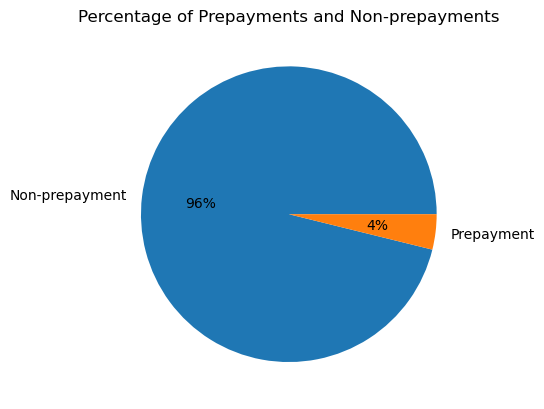

In [89]:
# Calculating the value counts for prepayments and non-prepayments.
Counts= merged_data['PREPAID'].value_counts()

# Creating the lables for the pie chart.
label=['Non-prepayment','Prepayment']

# Constructing the pie chart
plt.pie(Counts, labels=label, autopct = '%1.0f%%')

# show plot
plt.title("Percentage of Prepayments and Non-prepayments")
plt.show()

As shown in the pie chart above, 96% of clients did not prepay on their home loan whereas 4% prepaid. Therefore, the proportion of homeowners who did not prepay is greater than those that prepaid.

    Visualization 2 : Number of Prepayments each unemployment bucket.

In [90]:
# Creating the Prepayment dataset from the original data:
prepayment_df = merged_data[(merged_data['PREPAID']==1)]
# Counting prepayments in each unemployment bucket
prepayment_counts = prepayment_df.groupby('unemployment_buckets')['PREPAID'].count()

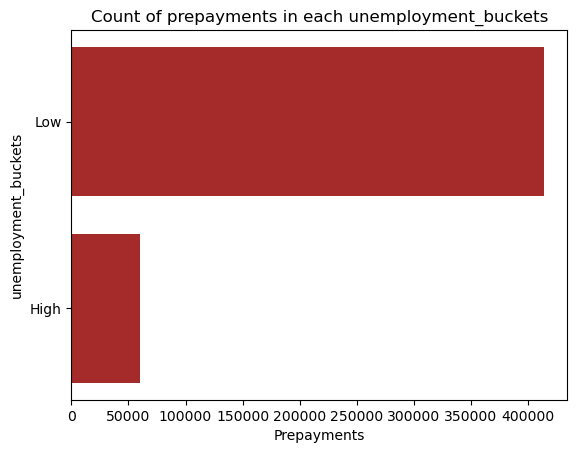

In [91]:
# Constructing a bar chart showing prepayment counts in each unemployment bucket
label=['High','Low'] # Creating lables for the prepaid variable
plt.barh(label,prepayment_counts, color='brown') # construsting a horizontal barchart.
plt.ylabel("unemployment_buckets")
plt.xlabel("Prepayments")
plt.title('Count of prepayments in each unemployment_buckets')
plt.show()

The bar chart visually inidicates that the count of prepayments changes betweem unemployment buckets. This sugggests that there may be a relationship between the unemployment rates and the likelihood to prepay a home loan.

     Visualization 3 : Boxplot of total taxes paid by homeowners grouped by whether they prepaid or not.

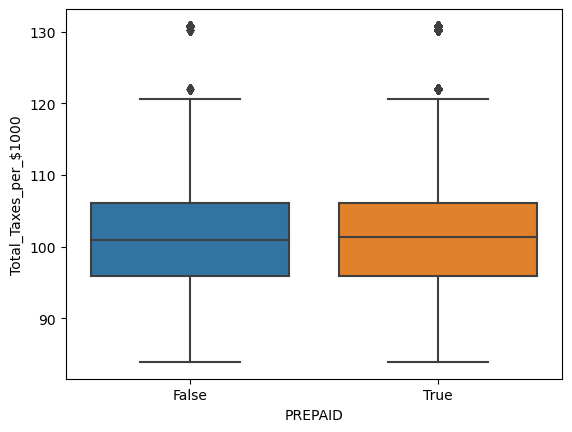

In [92]:
# Constructing a boxplot grouped by Prepaid.
ax=sns.boxplot(data=merged_data, x='PREPAID', y='Total_Taxes_per_$1000')
ax.set_xticklabels(["False","True"])
plt.show()

The distribution of state taxes appears to be the same regardless of the prepayment status of a homeowner and it has some outliers.Thus, total taxes paid in a state may not be related to the likelihood of a home owner to prepay.

    Visualization 4: Trend of home price index.

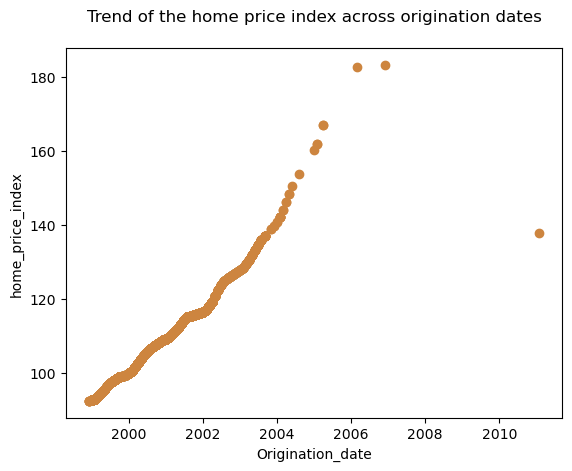

In [93]:
# Creating a scatterplot of mpg and weight
plt.scatter(merged_data['Origination_date'],merged_data['home_price_index'], c ="peru")
plt.title("Trend of the home price index across origination dates",y=1.05)
plt.xlabel("Origination_date")
plt.ylabel("home_price_index")

# To show the plot
plt.show()

The Home Price Index (HPI) is a broad measure of the movement of single-family property prices in the United States. As shown in the graph above, this variable has an outlier and its trend generally indicates that loans with more recent origination dates had higher prices.

    Visualization 5 : Distribution of the debt to income ratio.

In [94]:
# creating two datasets from the original data: prepayment and non-prepayment datasets
prepayment = merged_data[(merged_data['PREPAID']==1)]
non_prepayment= merged_data[(merged_data['PREPAID']==0)]

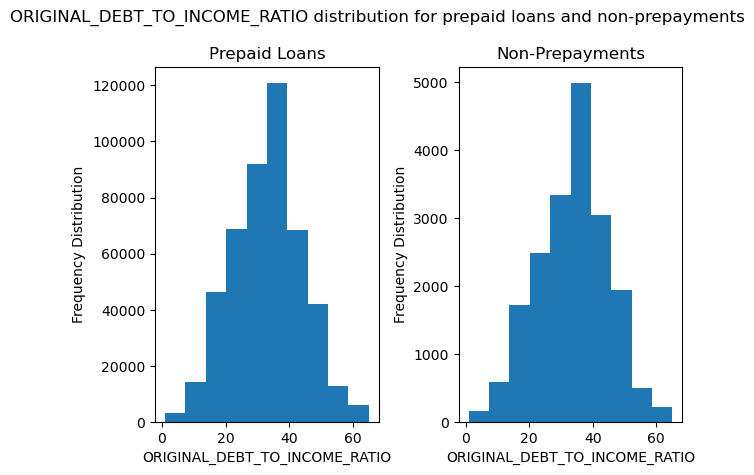

In [95]:
# Creating side by side histograms of ORIGINAL_DEBT_TO_INCOME_RATIO for prepaid loans and non-prepayments.
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('ORIGINAL_DEBT_TO_INCOME_RATIO distribution for prepaid loans and non-prepayments')
ax1.hist(prepayment['ORIGINAL_DEBT_TO_INCOME_RATIO'])
ax1.set_title('Prepaid Loans')
ax1.set(xlabel='ORIGINAL_DEBT_TO_INCOME_RATIO', ylabel='Frequency Distribution')
ax2.hist(non_prepayment['ORIGINAL_DEBT_TO_INCOME_RATIO'])
ax2.set_title('Non-Prepayments')
ax2.set(xlabel='ORIGINAL_DEBT_TO_INCOME_RATIO', ylabel='Frequency Distribution')
fig.tight_layout()

The distribution of original debt to income ratio is symmetric and the same for prepayments and non-prepayments.

    Visualization 6 : Assessing the linear relationship of selected variables.

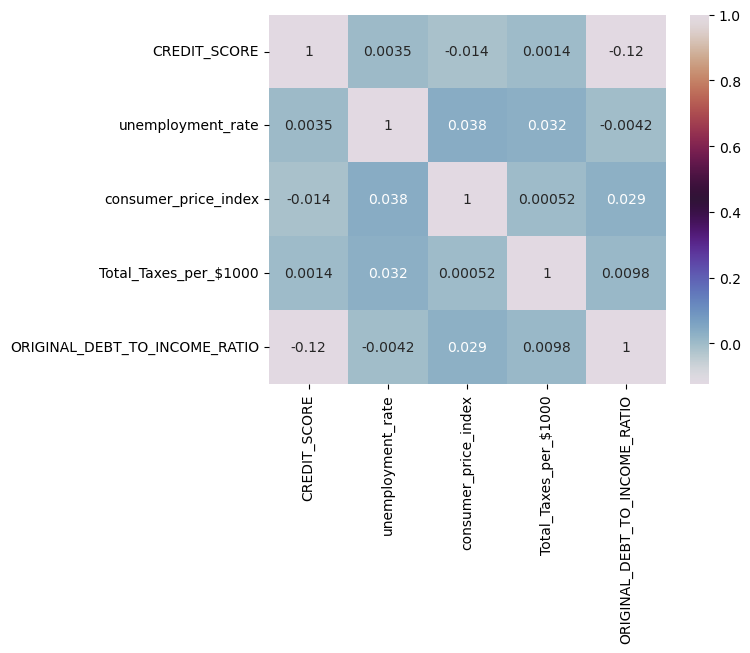

In [96]:
# Getting some numeric variables from all the merged data.
data = merged_data[['CREDIT_SCORE','unemployment_rate','consumer_price_index','Total_Taxes_per_$1000','ORIGINAL_DEBT_TO_INCOME_RATIO']]

# plotting correlation heatmap 
sns.heatmap(data.corr(),cmap = 'twilight', annot=True) 
  
# displaying heatmap 
plt.show()

Based on the correlation matrix above, no linear relationships were identified among selected variables. 

# Lessons Learned

<div style ="text-align:justify">
This project was challenging and worthwile. I learnt a lot from it,but the following key lessons standout:

- Lesson 1 : Data pulled from the three sources had some anomalies. Prior to conducting any analysis,it is important to ensure that the data you pulled is clean, regardless of where you pulled the data from.

- Lesson 2: Data preparation takes alot more time than data analysis. Nevertheless, its important to do it because any analysis is only as good as the quality of data which was used to perform it.

- Lesson 3: The data which was loaded to SQLLite had correct data types. However, after bringing it back into a pandas dataframe , some data types changed and these had to be corrected through a series of transformations before conducting data visualizations. Moving data from one location to another may distort the data. Data validation needs to be performed after moving data from one location to another to ensure that it remains clean.

- Lesson 4: Not all techniques i tried during data preparation worked. In some cases, I had to try multiple techniques before finally identifying the one which worked. To prepare data  for analysis, you need to be persistent and have an exploratory mindset.
</div>

#  Ethical Considerations

- The data does not include protected attributes such as race, religion, national origin, gender, marital status, age, and socioeconomic status of the homeowner. Therefore, the analysis will be free from bias based on a protected attribute.

- There are no federal laws against the  web scraping performed in this project since the scraped data is publicly available and the scraping activity did not harm the website which was scraped.

- Borrowers of loans in the flat file are anonymouse, and hence, no privacy concerns could be raised by them regarding the use of their data in this project.


# Final Data Printout

In [97]:
# print out of the final data.
merged_data

,CREDIT_SCORE,FIRST_PAYMENT_DATE,MATURITY_DATE,NUMBER_OF_UNITS,OCCUPANCY_STATUS,ORIGINAL_COMBINED_LOAN_TO_VALUE,ORIGINAL_DEBT_TO_INCOME_RATIO,ORIGINAL_UPB,ORIGINAL_LOAN_TO_VALUE,ORIGINAL_INTEREST_RATE,...,PREPAID,DELINQUENT,Origination_date,Total_Taxes_per_$1000,State_tax_Rank,unemployment_rate,home_price_index,consumer_price_index,unemployment_buckets,consumer_index_buckets
0,669.0,2002-06-01,2029-01-01,1.0,O,80.0,33.0,162000,80.0,7.120,...,1,0,2002-05-01,111.68,8,5.8,120.788,0.000000,High,Low
1,732.0,1999-04-01,2029-03-01,1.0,O,25.0,10.0,53000,25.0,6.500,...,1,0,1999-03-01,110.96,11,4.2,93.611,0.303951,Low,High
2,679.0,2002-08-01,2029-02-01,1.0,O,91.0,48.0,133000,91.0,6.750,...,1,0,2002-07-01,110.96,11,5.8,123.687,0.111173,High,Low
3,721.0,2002-09-01,2029-02-01,1.0,O,39.0,13.0,174000,39.0,6.625,...,1,0,2002-08-01,104.47,19,5.7,124.729,0.333148,High,High
4,618.0,2002-10-01,2029-02-01,1.0,O,85.0,24.0,122000,85.0,6.375,...,1,0,2002-09-01,110.96,11,5.7,125.494,0.166021,High,Low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494610,774.0,2002-03-01,2032-02-01,1.0,O,61.0,38.0,76000,61.0,6.625,...,1,0,2002-02-01,113.14,7,5.7,116.917,0.395257,High,High
494611,689.0,2002-03-01,2032-02-01,1.0,O,70.0,39.0,70000,70.0,6.625,...,1,0,2002-02-01,130.79,1,5.7,116.917,0.395257,High,High
494612,798.0,2002-03-01,2032-02-01,1.0,O,56.0,41.0,65000,56.0,6.625,...,1,0,2002-02-01,103.85,24,5.7,116.917,0.395257,High,High
494613,791.0,2002-03-01,2032-02-01,1.0,O,26.0,18.0,51000,26.0,6.625,...,1,0,2002-02-01,106.01,17,5.7,116.917,0.395257,High,High


In [ ]:
# Drop the home_loans table 
#cursor.execute("DROP TABLE home_loans") 
# Drop the state_taxes table 
#cursor.execute("DROP TABLE state_taxes") 

# Drop the macro_variables table 
#cursor.execute("DROP TABLE macro_variables")
# Drop the merged_datatable 
#cursor.execute("DROP TABLE merged_data")